<a href="https://colab.research.google.com/github/LokiAndere/ML-tutties/blob/main/singleFCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler as LRS
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import to_categorical

In [83]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer
from collections import Counter
import matplotlib.pyplot as plt

In [84]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [85]:
import keras.backend as BCKN
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import Dropout, Flatten, Dense, DepthwiseConv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization as BN
from keras.layers import ReLU, Softmax
from keras.utils.vis_utils import plot_model

In [86]:
def FCNN (shape, num_classes):
  def CR (model, filters):
    model = Conv2D(filters, 3) (model)
    model = ReLU() (model)
    return model

  def CRCRMP (model, filters):
    model = CR(model, filters)
    model = CR(model, filters)
    model = Conv2D(filters, 2, strides = 2) (model)
    return model

  def DR (model, filters):
    model = Dense(filters) (model)
    model = ReLU() (model)
    return model

  first = Input (shape)
  model = CRCRMP (first, 16)
  model = CRCRMP (model, 64)
  model = Dropout (0.2) (model)
  model = CR (model, 64)
  model = CR (model, 128)
  model = BN () (model)
  model = Flatten () (model)
  model = DR (model, 64)
  model = Dropout (0.2) (model)
  model = DR (model, 32)
  model = DR (model, 32)
  model = Dense (num_classes) (model)
  last = Softmax () (model)
  final = Model (first, last)
  return final

In [88]:
shape = (100, 100, 1)
num_classes = 2

In [94]:
BCKN.clear_session()
model = FCNN(shape, num_classes)
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 16)        160       
_________________________________________________________________
re_lu (ReLU)                 (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 16)        1040      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        9280  

In [8]:
def MobNet (shape, num_classes, alpha=1, ro=1, filter_one=32):

  #alpha should be 1/4, 1/2, 3/4, 1
  #basically between 0 and 1
  #it is a reduce multiplyer of net arcitecture
  #ro is reduce multiplyer of input image
  #also between 0 and 1

  #also additionally we included the number of filters to begin with
  #instead of 32 we can put another minimum 16 and then we grow it like 2**n

  #remember to reshape the image accordingly

  #block that puts batch normalization and relu
  #because we are tired of writing it each time
  def BNR(model):
    model = BN() (model)
    model = ReLU() (model)
    return model

  #standart block
  #you guessed it each convolution is proceeded with
  #batch normalization and linear rectifier relu
  def CBNR(model, filters, kernal, stride=1, padd='same'):
    model = Conv2D (filters, kernal, strides=stride, padding=padd) (model)
    model = BNR(model)
    return model

  #combo block
  #deepwise convolution, in this way we save computational potency
  #instead of one big convolutional block we brake it into two
  #the first one is deepwise second is simple convolution
  #less coeficients appear in this way
  #too bad we did not perserve time to play with permute in all these exercises
  #first convolution as easch convolution in this method
  #is proceeded with batch normalization and relu
  #and standart block inside
  #we mean look at the name
  #it is very self explainatory DCBNRCBNR
  #for those to whom it is hard to read this
  #we put a down underline separator
  def DCBNR_CBNR(model, filters, stride=1, padd='same'):
    model = DepthwiseConv2D(3, strides=stride, padding=padd) (model)
    model = BNR(model)
    model = CBNR(model, filters, 1)
    return model

  #we fill the arcitecture of light net
  def fill(alpha=1, filters=32):
    new_list = []
    if filters<16:
      filters = 32
    if alpha<=0 or 1<alpha:
        alpha=0.5
    for n in range(6):
        new_list.append(int(filters*alpha*2** n))
    return new_list

  if ro<=0 or 1<ro:
    ro=0.5
  tmp=list(int(s*ro) for s in shape[:-1])
  tmp.append(shape[-1])
  shape=tuple(tmp)

  first = Input(shape)
  #arch stends for arcitecture
  arch = fill(alpha, filter_one)
  #it seems like we can imagine a better automatization
  #like one complex cycle
  #because number of filters frows in a simple row a(n)=2^n
  #but at this point we have not figured out it
  #and from another point of view it is more readable
  #and corelates strongly to paper table
  model = CBNR(first, arch[0], 7, 2)
  model = DCBNR_CBNR(model, arch[1])
  model = DCBNR_CBNR(model, arch[2], 2)
  model = DCBNR_CBNR(model, arch[2])
  model = DCBNR_CBNR(model, arch[3], 2)
  model = DCBNR_CBNR(model, arch[3])
  model = DCBNR_CBNR(model, arch[4], 2)
  for _ in range (5):
    model = DCBNR_CBNR(model, arch[4])
  model = DCBNR_CBNR(model, arch[5], 2)
  #this one is strange. in the paper it is said to have stride step 2
  #but the dimentions say it has to have stride = 1
  model = DCBNR_CBNR(model, arch[5])

  #tail
  model = GlobalAveragePooling2D() (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

In [9]:
shape = (100, 100, 1)
num_classes = 2
alpha=0.25
romashka=1
first=16
BCKN.clear_session()
modelS = MobNet(shape, num_classes, alpha, romashka, first)
modelS.summary()
#plot_model(modelS, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 4)         200       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 4)         16        
_________________________________________________________________
re_lu (ReLU)                 (None, 50, 50, 4)         0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 50, 50, 4)         40        
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 4)         16        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 50, 4)         0     

In [10]:
def normalize_zero_simple(x):
  return (x.astype(float) - 128)/128

def normalize_channel_vise(x):
  x = x.astype('float32')
  return (x - x.mean(axis = (0, 1, 2), keepdims = True)) / x.std(axis = (0, 1, 2), keepdims = True)

def normalize_channel_vise_02(x):
  x = x.astype('float32')
  return zscore(x.reshape(-1, 3)).reshape(x.shape)

def normalize_manually(x):
  x = x.astype('float32')
  x /= 255.0
  return x

def global_centering(x):
  x = x.astype('float32') 
  x = x - x.mean()
  return x

def local_centering(x):
  x = x.astype('float32')
  means = x.mean(axis=(0,1), dtype='float64')
  x =  x - means
  return x

def global_standardization(x):
  x = x.astype('float32')
  mean, std = x.mean(), x.std()
  x = (x - mean) / std
  return x

def positive_global_standardization(x):
  x = x.astype('float32')
  mean, std = x.mean(), x.std()
  x = (x - mean) / std
  x = np.clip(x, -1.0, 1.0)
  x = 0.5 * (x + 1.0)
  return x

def local_standardization(x):
  x = x.astype('float32')
  means = x.mean(axis=(0,1), dtype='float64')
  stds = x.std(axis=(0,1), dtype='float64')
  x = (x - means) / stds
  return x

In [11]:
def draw_mpl(im, name = 'origin'):
  name = name.title()
  fig, ax = plt.subplots()
  fig.canvas.set_window_title(name.upper())
  ax.set_title(label=name, fontsize=16, color="black")
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.xaxis.set_ticks_position('top')
  ax.xaxis.set_label_position:('top')
  ax.xaxis.set_title_position:('top')
  plt.imshow(im, cmap='gray')
  plt.show()

In [26]:
DATA_PATH = '/content/drive/MyDrive/DefectDetection/100x100/'
ARR_PATH = '/content/drive/MyDrive/DefectDetection/tog.npz'
NARR_PATH = '/content/drive/MyDrive/DefectDetection/togn.npz'
data = np.load(ARR_PATH)
ndata = np.load(NARR_PATH)

In [103]:
#X, y = data['x'], data['y']
X, y = ndata['xn'], ndata['yn']
print(X.shape, y.shape)

(347, 100, 100) (347,)


In [55]:
#X = preprocess_input(X)
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = Normalizer()
scaler = StandardScaler()

In [90]:
for i in range (X.shape[0]):
  #X[i] = global_standardization(X[i])
  #X[i] = positive_global_standardization(X[i])
  X[i] = local_standardization(X[i])
  #X[i] = preprocessing.normalize(X[i]) #ok for 2 dimentions
  #X[i] = scaler.fit_transform(X[i])
  #X[i] = normalize_channel_vise_02(X[i])
  pass

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

(207,)
(70,)
(70,)
Counter({0: 129, 1: 78})
Counter({0: 44, 1: 26})
Counter({0: 43, 1: 27})


In [112]:
X_train = X_train.reshape(207,100,100,1)
X_test = X_test.reshape(70,100,100,1)
X_val = X_test.reshape(70,100,100,1)
X_train = X_train.astype('float32')
X_test =X_test.astype('float32')
X_val = X_val.astype('float32')

#X_train /= 255.0
#X_test /= 255.0
#X_val /= 255.0
y_train=to_categorical(y_train, num_classes)
y_test=to_categorical(y_test, num_classes)
y_val=to_categorical(y_val, num_classes)

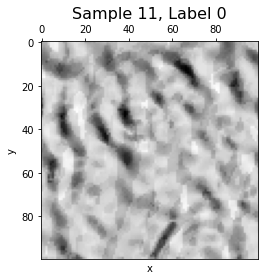

In [104]:
i = 11
draw_mpl(X[i], f"sample {i}, label {y[i]}")

In [114]:
modelS.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [73]:
#data_generator = ImageDataGenerator(samplewise_std_normalization=True, preprocessing_function=None)
#train_generator = data_generator.flow_from_directory('/content/drive/MyDrive/DefectDetection/100x100/', target_size=(100,100), color_mode='grayscale', batch_size=23, class_mode='categorical')
#test_generator = data_generator.flow_from_directory('/content/drive/MyDrive/DefectDetection/100x100/', target_size=(100,100), color_mode='grayscale', batch_size=23, class_mode='categorical')
#validation_generator = data_generator.flow_from_directory('/content/drive/MyDrive/DefectDetection/100x100/', target_size=(100,100), color_mode='grayscale', batch_size=23, class_mode='categorical')

Found 347 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
modelS.fit_generator(
    preprocess_function = preprocess_input,
    train_generator,
    steps_per_epoch=9,
    validation_data=test_generator,
    validation_steps=9)

In [115]:
batch_size = 9
epochs = 150

In [116]:
data_gen_with_aug = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [117]:
sgd=SGD(lr=0.1, decay=0.0, momentum=0.0)

def scheduler(epoch):
    if epoch < 50:
        return 0.1
    elif epoch < 100:
        return 0.01
    else:
        return 0.001

set_lr = LRS(scheduler)

In [118]:
metric = 'val_accuracy'
mcp_save = ModelCheckpoint ('/content/drive/MyDrive/DefectDetection/first.hdf5', verbose=2, save_best_only = True, monitor = metric, mode = 'max')

In [119]:
history = modelS.fit_generator(data_gen_with_aug.flow(X_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(X_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=[set_lr, mcp_save],
                            verbose=1)

score = modelS.evaluate(X_val, y_val, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
23/23 [==============================] - 2s 36ms/step - loss: 0.2633 - accuracy: 0.8843 - val_loss: 1.5080 - val_accuracy: 0.6571

Epoch 00001: val_accuracy improved from -inf to 0.65714, saving model to /content/drive/MyDrive/DefectDetection/first.hdf5
Epoch 2/150
23/23 [==============================] - 0s 16ms/step - loss: 0.1316 - accuracy: 0.9714 - val_loss: 0.3136 - val_accuracy: 0.8571

Epoch 00002: val_accuracy improved from 0.65714 to 0.85714, saving model to /content/drive/MyDrive/DefectDetection/first.hdf5
Epoch 3/150
23/23 [==============================] - 0s 16ms/step - loss: 0.2633 - accuracy: 0.8931 - val_loss: 0.5126 - val_accuracy: 0.8000

Epoch 00003: val_accuracy did not improve from 0.85714
Epoch 4/150
23/23 [==============================] - 0s 15ms/step - loss: 0.1856 - accuracy: 0.9348 - val_loss: 0.3054 - val_accuracy: 0.8857

Epoch 00004: val_accuracy improved from 0.85714 to 0.88571, saving model to /content/drive/MyDrive/DefectDetection/first.hdf

In [95]:
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(data_gen_with_aug.flow(X_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(X_train) / batch_size, 
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            verbose=1)

score = modelS.evaluate(X_val, y_val, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
23/23 [==============================] - 2s 35ms/step - loss: 0.6940 - accuracy: 0.5261 - val_loss: 0.6757 - val_accuracy: 0.6286
Epoch 2/150
23/23 [==============================] - 0s 13ms/step - loss: 0.6097 - accuracy: 0.7007 - val_loss: 0.6655 - val_accuracy: 0.7000
Epoch 3/150
23/23 [==============================] - 0s 13ms/step - loss: 0.5174 - accuracy: 0.7737 - val_loss: 0.6532 - val_accuracy: 0.6571
Epoch 4/150
23/23 [==============================] - 0s 14ms/step - loss: 0.6216 - accuracy: 0.7386 - val_loss: 0.6570 - val_accuracy: 0.6571
Epoch 5/150
23/23 [==============================] - 0s 13ms/step - loss: 0.5809 - accuracy: 0.7011 - val_loss: 0.6601 - val_accuracy: 0.6286
Epoch 6/150
23/23 [==============================] - 0s 13ms/step - loss: 0.5629 - accuracy: 0.7360 - val_loss: 0.6533 - val_accuracy: 0.6429
Epoch 7/150
23/23 [==============================] - 0s 13ms/step - loss: 0.5549 - accuracy: 0.7733 - val_loss: 0.6425 - val_accuracy: 0.7000
Epoch 

In [98]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
filepath='/content/drive/My Drive/DefectDetection/second.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit(X_train, y_train, validation_split=0.33, epochs=150, batch_size=9, callbacks=callbacks_list, verbose=0)
score = modelS.evaluate(X_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 00001: val_accuracy improved from -inf to 0.53623, saving model to /content/drive/My Drive/DefectDetection/second.hdf5

Epoch 00002: val_accuracy improved from 0.53623 to 0.57971, saving model to /content/drive/My Drive/DefectDetection/second.hdf5

Epoch 00003: val_accuracy did not improve from 0.57971

Epoch 00004: val_accuracy improved from 0.57971 to 0.73913, saving model to /content/drive/My Drive/DefectDetection/second.hdf5

Epoch 00005: val_accuracy did not improve from 0.73913

Epoch 00006: val_accuracy did not improve from 0.73913

Epoch 00007: val_accuracy did not improve from 0.73913

Epoch 00008: val_accuracy did not improve from 0.73913

Epoch 00009: val_accuracy did not improve from 0.73913

Epoch 00010: val_accuracy did not improve from 0.73913

Epoch 00011: val_accuracy did not improve from 0.73913

Epoch 00012: val_accuracy did not improve from 0.73913

Epoch 00013: val_accuracy did not improve from 0.73913

Epoch 00014: val_accuracy did not improve from 0.73913
